### Import Libraries

In [1]:
import featuretools as ft
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

### Import dataset

Source: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew

In [2]:
data = pd.read_csv('Data/Taxi_Trips.csv', nrows = 10000, parse_dates = ['Trip Start Timestamp', 'Trip End Timestamp'])
data.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,9cd9c0eefa2e3798b94c54e1c56ab32504b95c7b,9d5308a039a77963ed44f4b4435abd45f28eb7c4eb7669...,2014-10-20 18:00:00,2014-10-20 18:15:00,872,1.1,1.703108e+10,1.703108e+10,8.0,8.0,...,11.95,Credit Card,Flash Cab,41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),41.897984,-87.641492,POINT (-87.6414915334 41.897983898),37
1,8f66c1879e23e9a98c94fd3a3ede17c7858b0868,e765f58220125689ac5ca6ff4ec6d5641fb056dc419b47...,2014-10-28 17:15:00,2014-10-28 17:15:00,322,0.5,1.703184e+10,1.703132e+10,32.0,32.0,...,5.85,Cash,Flash Cab,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),38
2,c6db93351720f7e3a7f6222068da86ee22b7246b,1de34714972b96b5c1ca74ac6c6d0d4b76fc90319501e2...,2014-10-27 22:45:00,2014-10-27 22:45:00,520,2.4,1.703103e+10,1.703101e+10,77.0,1.0,...,11.75,Credit Card,Flash Cab,41.979912,-87.664188,POINT (-87.6641882421 41.9799124453),42.006279,-87.667684,POINT (-87.66768361010001 42.0062788614),76
3,fa8f1e4b580b376b1f88aa68ea9fb267491babf5,84957c8960b674346784746bbc1d48cafff4976b162323...,2014-10-19 10:15:00,2014-10-19 10:30:00,764,2.6,1.703108e+10,1.703133e+10,8.0,33.0,...,13.02,Credit Card,Flash Cab,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.859350,-87.617358,POINT (-87.6173580061 41.859349715),37
4,337c7a4d72f7eaf77f1313e72737467346dfeac5,c0a0eb1e50aed5d6f1d68c692c7b24abd3b4aac045b107...,2014-10-29 07:00:00,2014-10-29 07:00:00,277,1.2,NaN,NaN,24.0,28.0,...,6.85,Credit Card,Flash Cab,41.901207,-87.676356,POINT (-87.6763559892 41.90120699410001),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),25


### Preprocssing

In [3]:
data.drop(['Pickup Census Tract', 'Dropoff Census Tract','Tolls', 'Pickup Centroid Latitude', 
           'Pickup Centroid Longitude','Dropoff Centroid Latitude',
           'Dropoff Centroid Longitude', 'Community Areas', 
           'Pickup Centroid Location', 'Dropoff Centroid  Location'], axis = 1, inplace = True) 

In [4]:
data.dropna(inplace = True)

### Creating EntitySet

In [5]:
es = ft.EntitySet("taxi")

In [6]:
import featuretools.variable_types as vtypes
variable_types = {'Trip ID': vtypes.Categorical,
                  'Taxi ID': vtypes.Categorical,
                  'Pickup Community Area': vtypes.Categorical,
                  'Dropoff Community Area': vtypes.Categorical,
                  'Payment Type': vtypes.Categorical,
                  'Company': vtypes.Categorical}

In [7]:
es.entity_from_dataframe(entity_id = "trips",
                         dataframe = data,
                         index = "Trip ID",
                        variable_types=variable_types)

Entityset: taxi
  Entities:
    trips [Rows: 9756, Columns: 14]
  Relationships:
    No relationships

### Adding Entities

In [8]:
es.normalize_entity(base_entity_id="trips",
                    new_entity_id="taxis",
                    index = "Taxi ID",
                    additional_variables=['Company'])

Entityset: taxi
  Entities:
    trips [Rows: 9756, Columns: 13]
    taxis [Rows: 648, Columns: 2]
  Relationships:
    trips.Taxi ID -> taxis.Taxi ID

![](esplot.png)

### Primitives

In [9]:
trans_primitives = ['Minute', 'Hour', 'Day', 'Week', 'Month', 'Weekday', 'Is_weekend']
agg_primitives = ['sum', 'std', 'max', 'skew', 'min', 'mean', 'count', 'percent_true', 'num_unique', 'mode']

### Deep Feature Synthesis

In [10]:
feature_matrix, features = ft.dfs(entityset = es,
                                  target_entity = "trips",
                                  trans_primitives = trans_primitives,
                                  agg_primitives = agg_primitives,
                                  verbose=True)

Built 68 features
Elapsed: 00:04 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [18]:
features

[<Feature: Trip Seconds>,
 <Feature: Trip Miles>,
 <Feature: Fare>,
 <Feature: Tips>,
 <Feature: Extras>,
 <Feature: Trip Total>,
 <Feature: Taxi ID>,
 <Feature: Pickup Community Area>,
 <Feature: Dropoff Community Area>,
 <Feature: Payment Type>,
 <Feature: MINUTE(Trip Start Timestamp)>,
 <Feature: MINUTE(Trip End Timestamp)>,
 <Feature: HOUR(Trip Start Timestamp)>,
 <Feature: HOUR(Trip End Timestamp)>,
 <Feature: DAY(Trip Start Timestamp)>,
 <Feature: DAY(Trip End Timestamp)>,
 <Feature: WEEK(Trip Start Timestamp)>,
 <Feature: WEEK(Trip End Timestamp)>,
 <Feature: MONTH(Trip Start Timestamp)>,
 <Feature: MONTH(Trip End Timestamp)>,
 <Feature: WEEKDAY(Trip Start Timestamp)>,
 <Feature: WEEKDAY(Trip End Timestamp)>,
 <Feature: IS_WEEKEND(Trip Start Timestamp)>,
 <Feature: IS_WEEKEND(Trip End Timestamp)>,
 <Feature: taxis.Company>,
 <Feature: taxis.SUM(trips.Trip Seconds)>,
 <Feature: taxis.SUM(trips.Trip Miles)>,
 <Feature: taxis.SUM(trips.Fare)>,
 <Feature: taxis.SUM(trips.Tips)>,
 <F

### Encoding Features

In [11]:
feature_matrix_enc, feature_enc = ft.encode_features(feature_matrix, features)

In [12]:
X = feature_matrix_enc.drop(['Fare'], axis=1)
y = feature_matrix_enc['Fare']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Machine Learning

In [13]:
model = xgboost.XGBRegressor(max_depth=3, 
                             learning_rate=0.08, 
                             n_estimators=150,)
model.fit(X_train, y_train)

[08:32:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

### Evaluation

In [14]:
y_pred = model.predict(X_test)
y_pred[:10]

array([12.918643 ,  5.2647576,  5.383946 , 13.155612 ,  5.823556 ,
        8.085897 ,  5.2046614, 36.762867 , 40.025093 ,  9.931931 ],
      dtype=float32)

In [15]:
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

0.4336709563142188
0.26118988300650375


### Feature Importance Plot

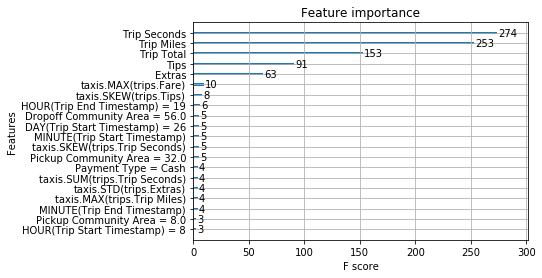

In [16]:
plot_importance(model, max_num_features = 20)
pyplot.show()